In [1]:
import os

# visualizing data
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import numpy as np
from imblearn.over_sampling import SMOTE  
train_on_gpu = torch.cuda.is_available()
# train_on_gpu = False
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is available.


In [2]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd

from skimage import io, transform
%matplotlib inline

### The image loader
Loading the image, resize, image preprocessing convert to tensor and returns the sample containing the data and label.

#### imshow:
display the 1 dimensional image

#### make_weights_for_balanced_classes:
balance the size of the classes, oversampling in the smaller classes

In [3]:
from __future__ import print_function, division

from skimage import io, transform
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import img_as_float, random_noise
from skimage.morphology import disk
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage.filters import gaussian, unsharp_mask
from skimage import exposure

class ImageLoader(Dataset):
  

    def __init__(self, data_frame, transform=None, Is_tumor=False, Is_train=False, randomize_images =True, add_noise=False):

        self.data_frame = data_frame
        self.transform = transform
        self.Is_train = Is_train        
        self.randomize_images = randomize_images
        self.add_noise= add_noise
        self.filepath= 'dataset/image/' 
        if Is_tumor:
            self.class_dic = {'meningioma_tumor':0,'glioma_tumor':0, 'pituitary_tumor':0, 'no_tumor':1}
        else:
            self.class_dic = {'meningioma_tumor':0,'glioma_tumor':1, 'pituitary_tumor':2, 'no_tumor':3}
        
        
    def __len__(self):
        return len(self.data_frame)
    

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
      
        image = io.imread(self.filepath + str(self.data_frame.iloc[idx, 0]), as_gray=True)
#         print(image.shape)
#         image = unsharp_mask(image, radius=3, amount=1)
#         image = exposure.equalize_hist(image)
#         image = exposure.equalize_adapthist(image, clip_limit=0.03)
        
        if self.Is_train and self.randomize_images and np.random.random() > 0.5:
            image = image[:, ::-1]
             
        labels = self.data_frame.iloc[idx, 1]
        if self.add_noise==True and labels=='no_tumor' and np.random.random() > 0.8:
            image = image[:, ::-1]
            image = resize(image, (224,224),anti_aliasing=True)
            image = image[3:-4, 3:-4]
            image = gaussian(image, sigma=2, multichannel=False)
        elif self.add_noise==True and labels=='meningioma_tumor' and np.random.random() > 0.95:
            image = image[:, ::-1]
            image = resize(image, (224,224),anti_aliasing=True)
            image = image[3:-4, 3:-4]
            image = gaussian(image, sigma=2, multichannel=False)           
        labels = self.class_dic[str(labels)]
        labels = np.array(labels)
        labels = labels.astype(np.float)
        sample = {'image': image, 'labels': labels}
        
            
        if self.transform:
            sample = self.transform(sample)
        return sample
    


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size_height,output_size_width):
        assert isinstance(output_size_height, (int, tuple))
        assert isinstance(output_size_width, (int, tuple))
        self.output_size_height = output_size_height
        self.output_size_width = output_size_width

    def __call__(self, sample):
        
            
              
        new_h, new_w = self.output_size_height,self.output_size_width
        new_h, new_w = int(new_h), int(new_w)
        
        image, labels = sample['image'], sample['labels']
        img = transform.resize(image, (new_h, new_w))
        
        
        return {'image': img, 'labels': labels}


    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    


    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        image = np.expand_dims(image, axis=2)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}


    
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)).squeeze(2), cmap=plt.get_cmap('gray'))  # convert from Tensor image

def make_weights_for_balanced_classes(dataframe, nclasses):                        
    count = [0] * nclasses                                                      
                                                             
        
    if nclasses==2:
        class_dic = {'meningioma_tumor':0,'glioma_tumor':0, 'pituitary_tumor':0, 'no_tumor':1}
        for idx in range(len(dataframe)):            
            count[class_dic[dataframe.iloc[idx, 1]]] += 1 
    else:
        class_dic = {'meningioma_tumor':0,'glioma_tumor':1, 'pituitary_tumor':2, 'no_tumor':3}
        for idx in range(len(dataframe)):            
            count[class_dic[dataframe.iloc[idx, 1]]] += 1  
    
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(dataframe)
    for idx in range(len(dataframe)):                                          
        weight[idx] = weight_per_class[class_dic[dataframe.iloc[idx, 1]]]                                  
    return weight 

- Decide the image size for data loader and the traing task: Tumnor_detection= True for Task A and Tumnor_detection= False for Task B

- Shuffle and split the data for training, validation and testing. 80% for training, 10% for testing and validation

In the later cell:
- weighted random sampler for training data
- decide the batch size
- visualize some images for a specific label


In [5]:
filepath = 'dataset/image/' 
pathidentity='dataset/'+'label.csv'
Tumnor_detection=False

data = pd.read_csv(pathidentity)


df=data
np.random.seed(33)
df = shuffle(df)
part=len(df)//10
print(part)
df_train = df[:int(8*part)]
df_test = df[int(8*part):int(9*part)]
df_val = df[int(9*part):]
thesize=256

brain_dataset_train = ImageLoader(df_train,transform=transforms.Compose([
                                               Rescale(thesize,thesize),                                             
                                               ToTensor()
                                           ]),Is_tumor=Tumnor_detection,Is_train=True, add_noise=True)
brain_dataset_test = ImageLoader(df_test,transform=transforms.Compose([
                                               Rescale(thesize,thesize),
                                               ToTensor()
                                           ]),Is_tumor=Tumnor_detection)
brain_dataset_val = ImageLoader(df_val,transform=transforms.Compose([
                                               Rescale(thesize,thesize),
                                               ToTensor()
                                           ]),Is_tumor=Tumnor_detection)



300


torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


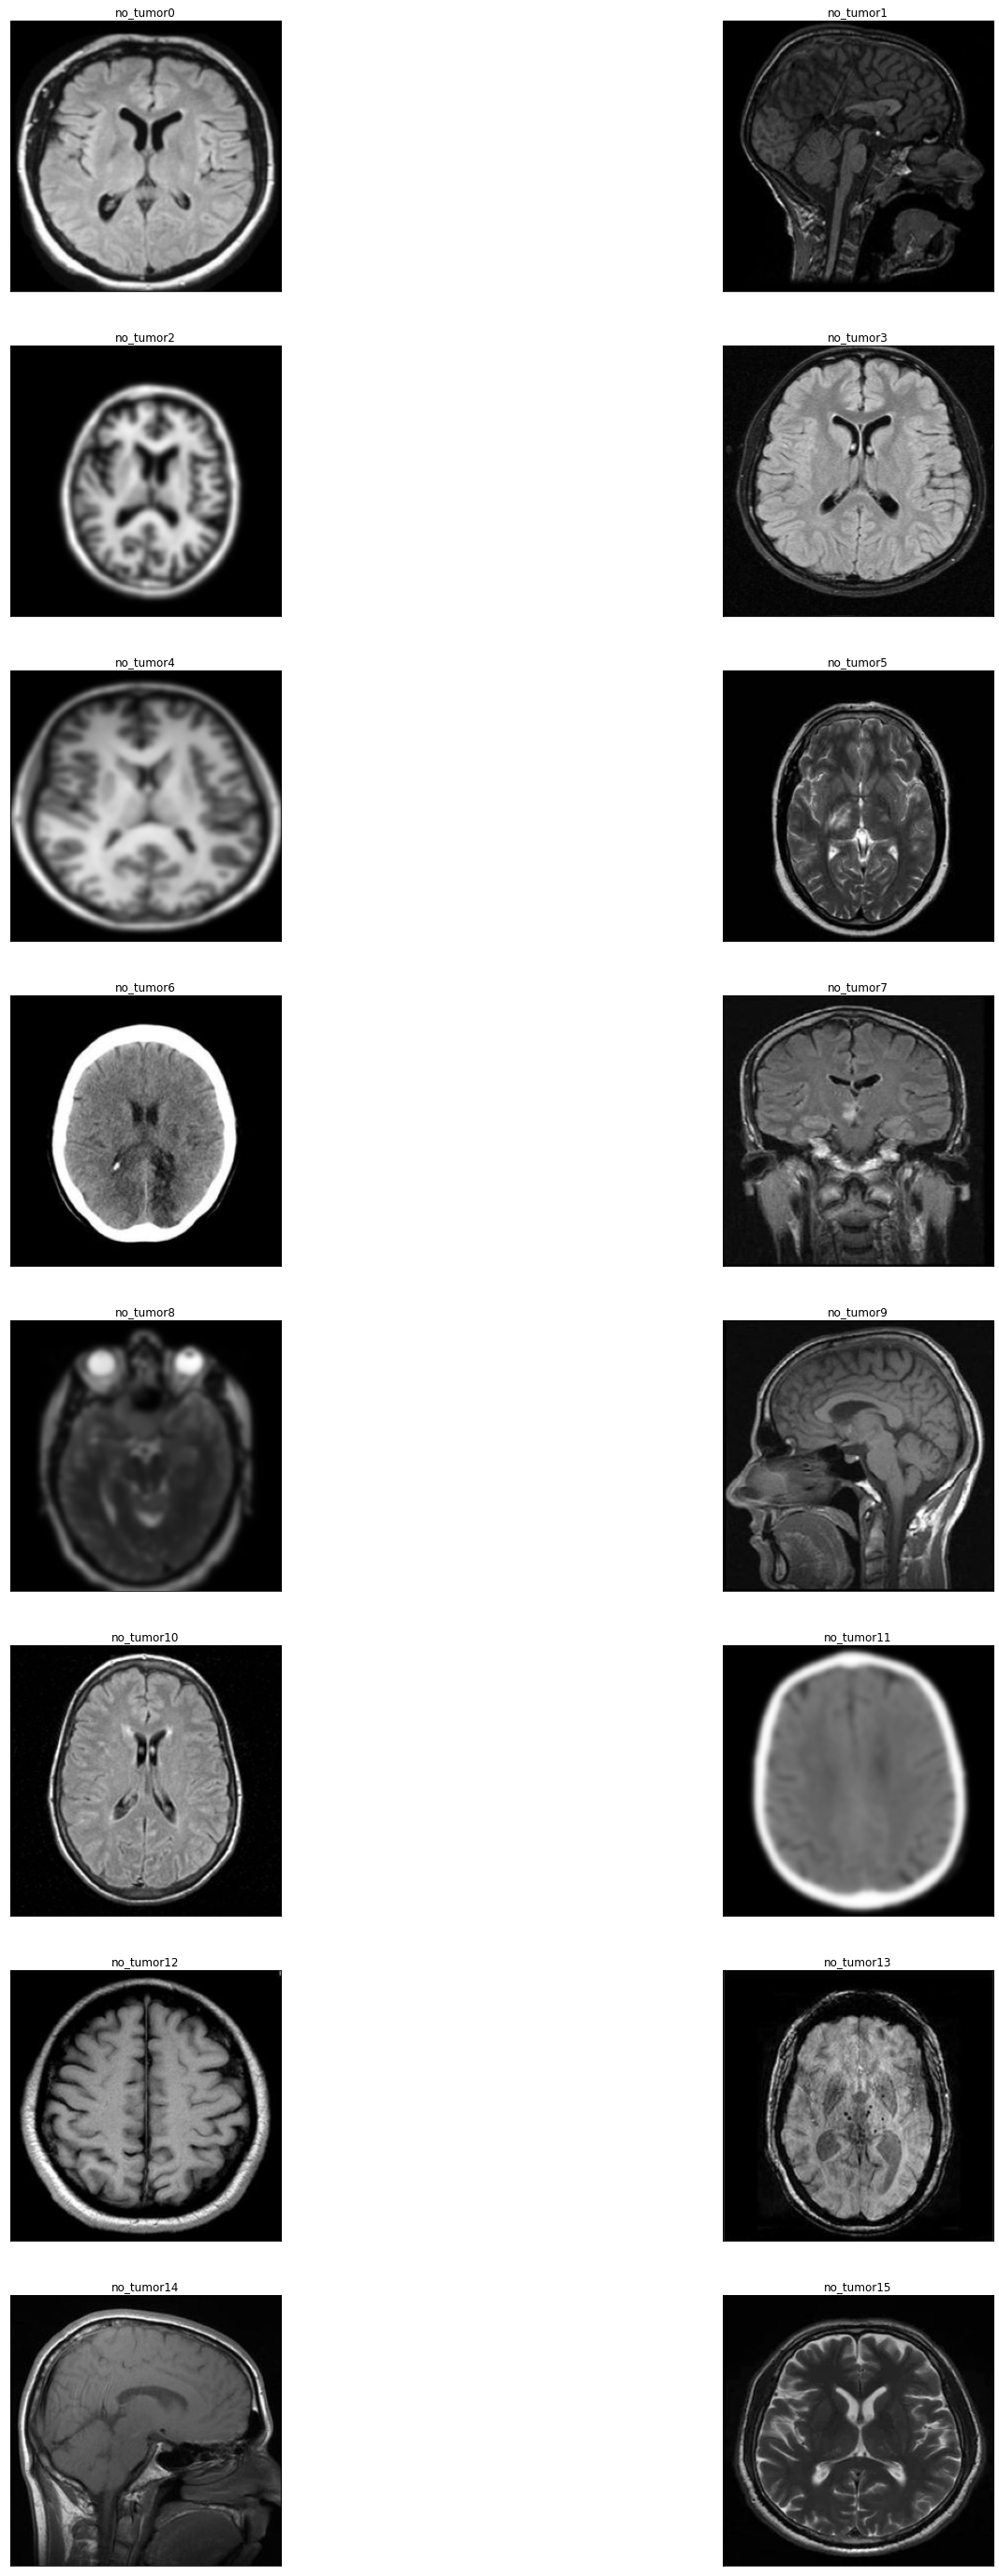

In [6]:
batch_size = 16
num_workers=0

if Tumnor_detection:
    classes = ['tumor', 'no_tumor']
    no_tumor_res=1
else:  
    # 0 for meningioma, 1 for glioma, 2 for pituitary tumor
    classes = ['meningioma_tumor','glioma_tumor', 'pituitary_tumor', 'no_tumor']
    num_classes=4
    no_tumor_res=3

weights = make_weights_for_balanced_classes(df_train, num_classes)                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 

    # create and return DataLoaders
train_loader = DataLoader(dataset=brain_dataset_train, batch_size=batch_size, 
                        sampler = sampler, num_workers=num_workers, pin_memory=True)

# train_loader = DataLoader(dataset=brain_dataset_train, batch_size=batch_size, 
#                         shuffle=True, num_workers=num_workers)

test_loader = DataLoader(dataset=brain_dataset_test, batch_size=batch_size, 
                         shuffle=True, num_workers=num_workers)

val_loader = DataLoader(dataset=brain_dataset_val, batch_size=batch_size, 
                         shuffle=True, num_workers=num_workers)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
fig = plt.figure(figsize=(25,50))

row_size=8
counter=0
plot_image=[]
plot_label=[]
class_count=[0 for _ in range(num_classes)]
    

for i_batch, sample_batched in enumerate(train_loader):
    images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
    print(images_batch.size())
    images_batch = images_batch.numpy()
    labels_batch = labels_batch.int()
    for idx in np.arange(batch_size):
        
        if labels_batch[idx]==no_tumor_res: 
            plot_image.append(images_batch[idx])
            plot_label.append(str(classes[labels_batch[idx]])+str(counter))
            counter+=1
        if counter == batch_size:
            break
    if counter == batch_size:
        break         
plot_image=np.array(plot_image)
plot_label=np.array(plot_label)

for idx in np.arange(batch_size):
    ax = fig.add_subplot(row_size, batch_size/row_size, idx+1, xticks=[], yticks=[])
    imshow(plot_image[idx])
    ax.set_title(plot_label[idx])
    
#     for idx in np.arange(batch_size):
#         print(images_batch[idx])
#         if labels_batch[idx]==3: 
#             print('yes')
#             print(images_batch[idx])
# #             ax = fig.add_subplot(row_size, batch_size/row_size, idx+1, xticks=[], yticks=[])
# #             imshow(images_batch[idx])
# #             ax.set_title(str(classes[labels_batch[idx]])+str(counter))
# #             print(counter)
#             counter+=1
#         if counter == batch_size:
#             break
#     if counter == batch_size:
#         break   
# print(plot_image) 


    
#     for idx in range(batch_size):  
# #         print(images_batch[idx],counter)
#         ax = fig.add_subplot(row_size, batch_size/row_size, idx+1, xticks=[], yticks=[])
#         imshow(images_batch[idx])
#         ax.set_title(str(classes[labels_batch[idx]])+str(counter))
#         counter+=1
#         if counter == batch_size:
#             break
#     if counter == batch_size:
#         break




### Classifier Structure

In [7]:

import torch.nn.functional as F

# define the CNN architecture
class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
       
        # max pooling layer
        self.pool1 = nn.MaxPool2d((2, 2),2)
        #linear layer (512 -> 2)
#         self.fc1 = nn.Linear(50176,1024) # for size 224
        self.fc1 = nn.Linear(65536,1024) # for size 256
        self.fc3 = nn.Linear(1024, 4)
#         self.LeakyReLU = nn.LeakyReLU(0.01)
        self.LeakyReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.30)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x =  self.pool1(self.LeakyReLU(self.conv1(x)))
        x = self.pool1(self.LeakyReLU(self.conv2(x)))
        x =  self.pool1(self.LeakyReLU(self.conv3(x)))
        x =  self.pool1(self.LeakyReLU(self.conv4(x)))
#         print(x.size())
        # flatten image input
#         x = x.view(-1, 50176) # for size 224
        x = x.view(-1, 65536) # for size 256

        
        # add 1st hidden layer, with relu activation function
        x = self.LeakyReLU(self.fc1(x))
        x = self.dropout(x)
        x = self.fc3(x)
#         x=F.tanh(x)
        return x

# # create a complete CNN
# # model = Net()


- Load the model
- Loss function and optimiser

In [8]:
# from Models.Discriminator_ResidualAttentionNetwork3232ACC69 import ResidualAttentionModel_92_32input_update
# from Models.Discriminator_ResNet import resnet152, resnet101, resnet50
# from Models.Discriminator_VGG import vgg19, vgg19_bn
# from Models.Discriminator_efficientnet import efficientnet_b0
# from Models.Discriminator_densenet import DenseNet, densenet201
# from Models.Discriminator_shufflenetv2 import shufflenet_v2_x2_0
# from Models.Discriminator_mobilenetv3 import mobilenet_v3_large, mobilenet_v3_small
# from Models.Discriminator_mnasnet import mnasnet1_0
# from Models.Discriminator_regnet import regnet_x_32gf
# from Models.Discriminator_visiontransformer import VisionTransformer, CONFIGS, AverageMeter
# from Models.Discriminator_crossvit import CrossViT
# from Models.Discriminator_focal_transformer import FocalTransformer
# from Models.Discriminator_imagetransformer import ImageTransformer
# from Models.research256_light_classifierACC59 import Net
# from Models.Discriminator_residualattentionmodel import ResidualAttentionModel_92_32input_update, ResidualAttentionModel_92
# from Models.Discriminator_DistilledVisionTransformer import deit_base_distilled_patch16_224, DistillationLoss
# from Models.Discriminator_CSWintransformer import CSWin_144_24322_large_224, CSWin_96_24322_base_224

# model=ResidualAttentionModel_92_32input_update()
# model=resnet152(num_classes=num_classes)
# from research256_light_classifierACC59 import Net

# model = efficientnet_b0(num_classes=num_classes)
# model = DenseNet(num_classes=num_classes)
# model = shufflenet_v2_x2_0(num_classes=num_classes)
# model = mobilenet_v3_large(num_classes=num_classes)
# model = densenet201(num_classes=num_classes)
# model = vgg19(num_classes=num_classes)
# model = mnasnet1_0(num_classes=num_classes)
# model = regnet_x_32gf(num_classes=num_classes)

# config = CONFIGS["ViT-B_16"]#choices=["ViT-B_16", "ViT-B_32", "ViT-L_16","ViT-L_32", "ViT-H_14", "R50-ViT-B_16"]
# model = VisionTransformer(config,img_size=thesize, num_classes=num_classes)

# model = CrossViT(thesize, 1, num_classes)
# model = FocalTransformer(img_size=thesize, in_chans=1,num_classes=num_classes,embed_dim=128, depths=[2,2,18,2], drop_path_rate=0.2, 
#         focal_levels=[2,2,2,2], expand_sizes=[3,3,3,3], expand_layer="all", 
#         num_heads=[4,8,16,32],
#         focal_windows=[7,5,3,1], window_size=7,
#         use_conv_embed=False, use_shift=False, 
#     )

# model = ImageTransformer(image_size=thesize, patch_size=8, num_classes=num_classes, channels=1,
#             dim=64, depth=6, heads=8, mlp_dim=128)

model = myNet()
# model = ResidualAttentionModel_92(num_classes=num_classes)

# model = deit_base_distilled_patch16_224()
# model=CSWin_96_24322_base_224(num_classes=num_classes)

if train_on_gpu:
    model.cuda()
criterion = nn.CrossEntropyLoss()

# distillation_type = 'none' #choices=['none', 'soft', 'hard']
# criterion = DistillationLoss(
#     criterion, 'none',distillation_type , 0.5, 1)

# optimizer
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=3e-4)

# # # specify optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# criterion = torch.nn.MSELoss()
# criterion = torch.nn.MSELoss(reduction = 'sum')
# discriminator_criterion = lpips.LPIPS(net='vgg').cuda()
# discriminator_criterion = lpips.LPIPS().cuda()
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.AdamW(model.parameters())
model

myNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=4, bias=True)
  (LeakyReLU): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [9]:
n_epochs = 200
last_epochs=0
train_loss_res=[]
valid_loss_res=[]
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    #_______________________ training ________________________#
    model.train()
    for i_batch, sample_batched in enumerate(train_loader):
        images_batch,labels_batch = sample_batched['image'], sample_batched['labels']
        img=images_batch.float()
        target = labels_batch.long()
        if train_on_gpu:
            img, target = img.cuda(), target.cuda()
    
        optimizer.zero_grad()
        output = model(img)
#         print(target)


#         print(output,output.size())
#         loss = criterion(img, output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*img.size(0)
        
 
    #_______________________ validation ________________________#

    model.eval()
    for i_batch, sample_batched in enumerate(val_loader):
        images_batch,labels_batch = sample_batched['image'], sample_batched['labels']
        img=images_batch.float()
        target = labels_batch.long()
        if train_on_gpu:
            img, target = img.cuda(), target.cuda()
        output = model(img)
        

#         loss = criterion(img, output, target)
        loss = criterion(output, target)
        valid_loss += loss.item()*img.size(0)
    

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(test_loader.sampler)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    train_loss_res.append(train_loss)
    valid_loss_res.append(valid_loss)

    if valid_loss <= valid_loss_min:
        last_epochs=epoch
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    if epoch-last_epochs>20:
        break

Epoch: 1 	Training Loss: 1.063514 	Validation Loss: 0.762169
Validation loss decreased (inf --> 0.762169).  Saving model ...
Epoch: 2 	Training Loss: 0.691504 	Validation Loss: 0.676558
Validation loss decreased (0.762169 --> 0.676558).  Saving model ...
Epoch: 3 	Training Loss: 0.569089 	Validation Loss: 0.578316
Validation loss decreased (0.676558 --> 0.578316).  Saving model ...
Epoch: 4 	Training Loss: 0.441228 	Validation Loss: 0.574335
Validation loss decreased (0.578316 --> 0.574335).  Saving model ...
Epoch: 5 	Training Loss: 0.332765 	Validation Loss: 0.501181
Validation loss decreased (0.574335 --> 0.501181).  Saving model ...
Epoch: 6 	Training Loss: 0.274147 	Validation Loss: 0.531188
Epoch: 7 	Training Loss: 0.205866 	Validation Loss: 0.531815
Epoch: 8 	Training Loss: 0.169067 	Validation Loss: 0.441544
Validation loss decreased (0.501181 --> 0.441544).  Saving model ...
Epoch: 9 	Training Loss: 0.143651 	Validation Loss: 0.414988
Validation loss decreased (0.441544 --> 0.

KeyboardInterrupt: 

- Plotting the training and validation loss 
- Record the loss information into loss_recorder.txt

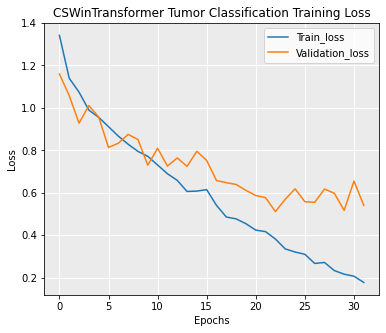

In [9]:

if valid_loss_res:
    x= [i for i in range(len(valid_loss_res))]
    fig,axes= plt.subplots(figsize=(6,5))
    plt.plot(x, train_loss_res, label = "Train_loss")
    plt.plot(x,valid_loss_res, label = "Validation_loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if num_classes==2:
        the_target='Tumor Dection'
    else:
        the_target='Tumor Classification'
    axes.set_title(str(model.__class__.__name__)+ ' '+the_target+ ' '+'Training Loss')
    axes.legend()
    axes.set_facecolor('#EBEBEB')
    axes.grid(which='major', color='white', linewidth=1)
    plt.show()
with open('loss_recorder.txt', 'a') as f:
    f.write(str(model.__class__.__name__)+ '  '+str(num_classes)+ '  '+'image size'+ str(thesize)+':')
    f.write('\n')
    for item in zip(valid_loss_res,valid_loss_res):
        f.write(str(item[0])+'   '+str(item[0]))
        f.write('\n')


#### Load pretrained model parameter for transfer learning

In [15]:
pretrained_dict = torch.load('shufflenet_v2_x2_0_dectectionACC98.pt')
model_dict = model.state_dict(pretrained_dict)
print(len(pretrained_dict.items()))
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict) 
model.load_state_dict(pretrained_dict)

338


<All keys matched successfully>

In [9]:
# model.load_state_dict(torch.load('densenet201_detectionACC98.pt'))
# model.load_state_dict(torch.load('efficientnet_b0ACC88.pt'))
model.load_state_dict(torch.load('mynetacc93.pt'))

<All keys matched successfully>

### Test the prediction accuracy

In [10]:

test_loss = 0
class_correct = [0 for _ in range(num_classes)]
class_total = [0 for _ in range(num_classes)]

model.eval()

counter=0
for i_batch, sample_batched in enumerate(test_loader):
    images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
    img=images_batch.float()
    target = labels_batch.long()
    if train_on_gpu:
        img,  target = img.cuda(), target.cuda()

    output = model(img)
    loss = criterion( output, target)

#     loss = criterion(img, output, target)

    test_loss += loss.item()*img.size(0)

    _, pred = torch.max(output, 1)    

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    for i in range(batch_size):
#         print(counter)
        if counter==len(df)//10:# the length of the testing set
            break
#         label = target.data
#         class_correct[label] += correct.item()
        label = target[i].data
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        counter += 1
       
    # average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))



Test Loss: 0.375436

Test Accuracy of meningioma_tumor: 86% (64/74)
Test Accuracy of glioma_tumor: 93% (93/99)
Test Accuracy of pituitary_tumor: 96% (86/89)
Test Accuracy of no_tumor: 89% (34/38)

Test Accuracy (Overall): 92% (277/300)


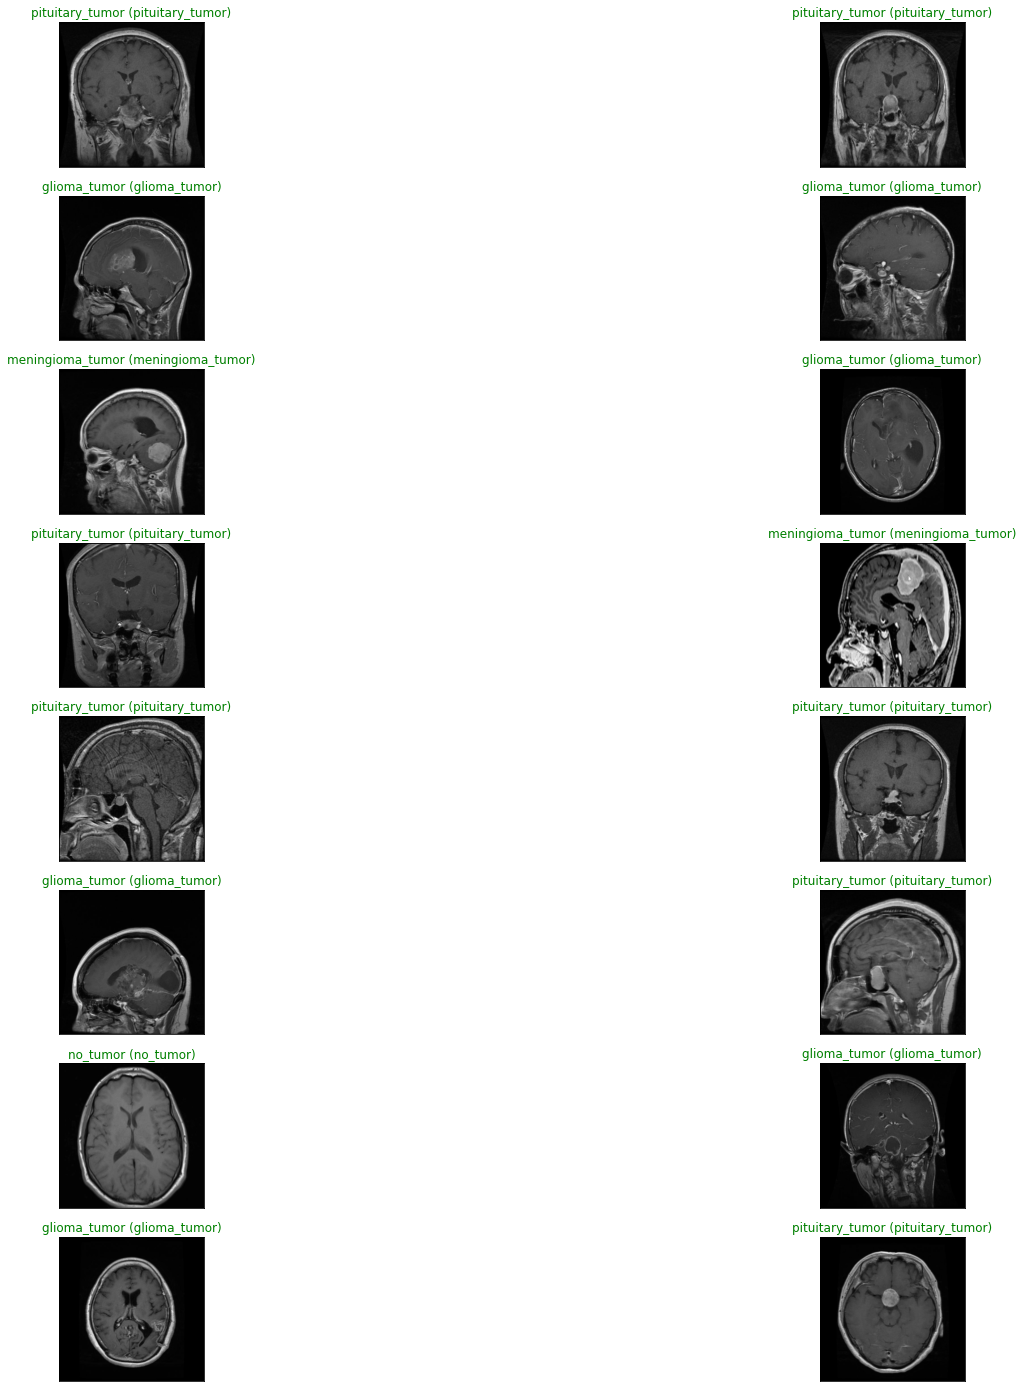

In [11]:
dataiter = iter(test_loader)
sample_batched = dataiter.next()
images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
img=images_batch.float()
target = labels_batch.long()
if train_on_gpu:
    img,  target = img.cuda(), target.cuda()

# get sample outputs
output = model(img)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25,25))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(8, batch_size/8, idx+1, xticks=[], yticks=[])
    imshow(img.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx].item() else "red"))